In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import scipy as osp

from vb_lib import structure_model_lib, data_utils, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

import time
from copy import deepcopy 

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# load data

In [2]:
# data_file = '../../../../fastStructure/test/testdata.npz'

# data_file = '../../../../fastStructure/hgdp_data/huang2011_plink_files/' + \
#                 'phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'

data_file = '../data/huang2011_subsampled.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [3]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [4]:
print(n_obs)
print(n_loci)

250
600


# Load fits

In [5]:
import os
import re

In [6]:
fits_dir = '../fits/fits_20201112/'
filenames = 'huang2011_sub_fit_alpha*'

In [7]:
files = [f for f in os.listdir(fits_dir) if (re.match(filenames, f))]

In [8]:
print(len(files))

21


In [9]:
files

['huang2011_sub_fit_alpha10.0.npz',
 'huang2011_sub_fit_alpha1.0.npz',
 'huang2011_sub_fit_alpha4.5.npz',
 'huang2011_sub_fit_alpha8.5.npz',
 'huang2011_sub_fit_alpha11.0.npz',
 'huang2011_sub_fit_alpha5.5.npz',
 'huang2011_sub_fit_alpha9.5.npz',
 'huang2011_sub_fit_alpha3.0.npz',
 'huang2011_sub_fit_alpha6.5.npz',
 'huang2011_sub_fit_alpha2.0.npz',
 'huang2011_sub_fit_alpha7.5.npz',
 'huang2011_sub_fit_alpha9.0.npz',
 'huang2011_sub_fit_alpha5.0.npz',
 'huang2011_sub_fit_alpha8.0.npz',
 'huang2011_sub_fit_alpha4.0.npz',
 'huang2011_sub_fit_alpha10.5.npz',
 'huang2011_sub_fit_alpha1.5.npz',
 'huang2011_sub_fit_alpha7.0.npz',
 'huang2011_sub_fit_alpha2.5.npz',
 'huang2011_sub_fit_alpha6.0.npz',
 'huang2011_sub_fit_alpha3.5.npz']

### load first fit to get metadata

In [10]:
_, vb_params_paragami, meta_data = \
    paragami.load_folded(fits_dir + files[0])

# logitnormal parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

# prior parameters for population beta
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

### Load all fits

In [11]:
vb_refit_list = []
alpha_vec = onp.zeros(len(files))

for i in range(len(files)): 
    
    print('loading fit from: ', files[i])
    
    # load fit
    vb_params_dict, vb_params_paragami, meta_data = \
        paragami.load_folded(fits_dir + files[i])
    
    # check KL
    prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
    
    kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                gh_loc, gh_weights)
    
    assert np.abs(kl - meta_data['final_kl']) < 1e-8
    
    # save alpha and fitted parametrs
    alpha_vec[i] = meta_data['dp_prior_alpha']
    vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
alpha_vec = np.array(alpha_vec)
vb_refit_list = np.array(vb_refit_list)

loading fit from:  huang2011_sub_fit_alpha10.0.npz
loading fit from:  huang2011_sub_fit_alpha1.0.npz
loading fit from:  huang2011_sub_fit_alpha4.5.npz
loading fit from:  huang2011_sub_fit_alpha8.5.npz
loading fit from:  huang2011_sub_fit_alpha11.0.npz
loading fit from:  huang2011_sub_fit_alpha5.5.npz
loading fit from:  huang2011_sub_fit_alpha9.5.npz
loading fit from:  huang2011_sub_fit_alpha3.0.npz
loading fit from:  huang2011_sub_fit_alpha6.5.npz
loading fit from:  huang2011_sub_fit_alpha2.0.npz
loading fit from:  huang2011_sub_fit_alpha7.5.npz
loading fit from:  huang2011_sub_fit_alpha9.0.npz
loading fit from:  huang2011_sub_fit_alpha5.0.npz
loading fit from:  huang2011_sub_fit_alpha8.0.npz
loading fit from:  huang2011_sub_fit_alpha4.0.npz
loading fit from:  huang2011_sub_fit_alpha10.5.npz
loading fit from:  huang2011_sub_fit_alpha1.5.npz
loading fit from:  huang2011_sub_fit_alpha7.0.npz
loading fit from:  huang2011_sub_fit_alpha2.5.npz
loading fit from:  huang2011_sub_fit_alpha6.0.n

In [12]:
# for convencience, sort the alphas 
_indx = np.argsort(alpha_vec)
alpha_vec = alpha_vec[_indx]
vb_refit_list = vb_refit_list[_indx]

In [13]:
# _indx2 = np.arange(len(alpha_vec), step = 2)
# alpha_vec = alpha_vec[_indx2]
# vb_refit_list = vb_refit_list[_indx2]

In [14]:
alpha_vec

DeviceArray([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
              6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
             11. ], dtype=float64)

In [15]:
# no gaps 
np.all(np.diff(alpha_vec) == 0.5)

DeviceArray(True, dtype=bool)

# Define the initial fit

In [16]:
alpha0 = 3.0

which_fit = (alpha_vec == alpha0)

vb_opt = vb_refit_list[which_fit].squeeze()
vb_opt_dict = vb_params_paragami.fold(vb_opt,
                                      free = True)

### Plot initial fit

Text(0.5, 0, 'Individuals')

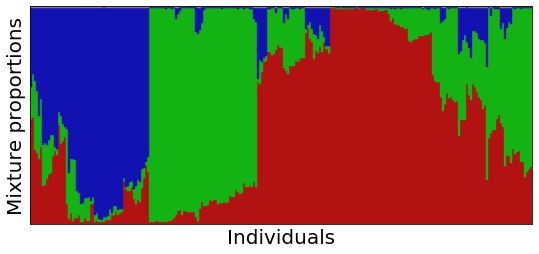

In [17]:
e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]
# re-order individuals for better plotting
indx = data_utils.cluster_admix_get_indx(e_ind_admix)

f, axarr = plt.subplots(1, 1, figsize=(9, 4))
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 3)

axarr.set_ylabel('Mixture proportions', fontsize = 20)
axarr.set_xlabel('Individuals', fontsize = 20)

### expected number of clusters

In [18]:
seed = 2342
key = jax.random.PRNGKey(seed)

@jax.jit
def get_e_num_clusters(vb_params_dict): 
    # TODO this is super slow ...
    return 0.
#     return structure_model_lib.get_e_num_clusters(g_obs, vb_params_dict, gh_loc, gh_weights, 
#                                                    n_samples = 1000,
#                                                    threshold = n_obs * n_loci * 0.001,
#                                                    seed = seed)

@jax.jit
def get_e_num_pred_clusters(vb_params_dict): 
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key = key, n_samples = 100)

In [19]:
get_e_num_clusters(vb_opt_dict)

0.0

In [20]:
get_e_num_pred_clusters(vb_opt_dict)

DeviceArray(3.95089836, dtype=float64)

# Define sensitivity object

In [21]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = use_free_alpha)

In [22]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


### Get hessian solver

In [23]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_sqrt = False, 
                                            return_info = True)

### Compute VB sensitivity derivatives

In [24]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)

Compiling ...
Compile time: 155.33sec



# Get linear reponse predictions

In [25]:
import multiprocessing
num_cores = multiprocessing.cpu_count() - 2
from joblib import Parallel, delayed

In [26]:
# I REALLY dont get why this won't work for in-sample clusters .... 
# this is so confusing ... 
def get_num_clusters_vec(vb_free_params_list, cluster_fun): 
    # vb_free_params_list contains an array of 
    # vb free parameters, where each row contains 
    # parameters from a different refit (or lr prediction)
    
    # cluster fun takes input a vb parameter dictionary 
    # and returns the posterior expectation of interest
        
    def fun(vb_free_params_list_i): 
                
        # fold 
        vb_dict = vb_params_paragami.fold(vb_free_params_list_i, 
                                          free = True)
        
        # get number of clusters 
        return cluster_fun(vb_dict)
    
    n_clusters_vec = Parallel(n_jobs=num_cores)(delayed(fun)(x) for x in vb_free_params_list)
    
    return np.stack(n_clusters_vec)

In [27]:
# def get_num_clusters_vec(vb_free_params_list, cluster_fun): 
#     # vb_free_params_list contains an array of 
#     # vb free parameters, where each row contains 
#     # parameters from a different refit (or lr prediction)
    
#     # cluster fun takes input a vb parameter dictionary 
#     # and returns the posterior expectation of interest
    
#     n_refit = len(vb_free_params_list)
#     n_clusters_vec = onp.zeros(n_refit)
    
#     for i in range(n_refit): 
#         print(i)
#         # fold 
#         vb_dict = vb_params_paragami.fold(vb_free_params_list[i], 
#                                           free = True)

#         # get number of clusters
#         n_clusters_vec[i] = cluster_fun(vb_dict)
    
#     return n_clusters_vec

In [28]:
def get_lr_predictions(vb_sens): 

    t0 = time.time()
    lr_free_params_list = []
    for i in range(len(alpha_vec)): 
    
        # get lr predicted parameters
        alpha_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha_vec[i],
                                                                     free = use_free_alpha)

        lr_free = vb_sens.predict_opt_par_from_hyper_par(alpha_pert)
        
        lr_free_params_list.append(lr_free)
    
    # computing the vb parameters are fast!
    print('lr time: {:03f}secs'.format(time.time() - t0))
    
    # actually computing the posterior quantity can be slow
    return lr_free_params_list


In [29]:
lr_free_params_list = get_lr_predictions(vb_sens)

lr time: 0.162500secs


In [30]:
lr_n_clusters_vec = get_num_clusters_vec(lr_free_params_list, get_e_num_clusters)
lr_n_pred_clusters_vec = get_num_clusters_vec(lr_free_params_list, get_e_num_pred_clusters)

# compare against refit results

In [31]:
refit_n_clusters_vec = get_num_clusters_vec(vb_refit_list, get_e_num_clusters)
refit_n_pred_clusters_vec = get_num_clusters_vec(vb_refit_list, get_e_num_pred_clusters)

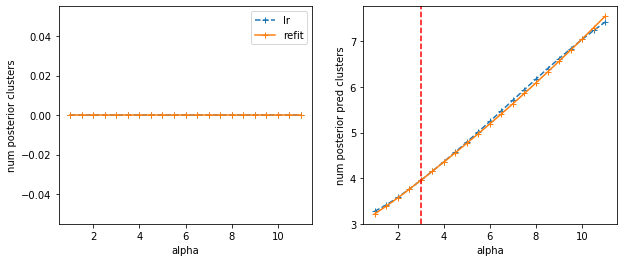

In [32]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# plot in-sample results
axarr[0].plot(alpha_vec, lr_n_clusters_vec, '+--')
axarr[0].plot(alpha_vec, refit_n_clusters_vec, '+-')

axarr[0].set_xlabel('alpha')
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend(('lr', 'refit'))

# plot posterior-predictive results
axarr[1].plot(alpha_vec, lr_n_pred_clusters_vec, '+--')
axarr[1].plot(alpha_vec, refit_n_pred_clusters_vec, '+-')

axarr[1].set_xlabel('alpha')
axarr[1].set_ylabel('num posterior pred clusters')

plt.axvline(alpha0, color = 'red', linestyle = 'dashed')

In [57]:
for i in range(len(alpha_vec)): 
    np.savez('./figures/tmp/refit_results_ap{}'.format(alpha_vec[i]), 
            free_params = vb_refit_list[i], 
            alpha_pert = alpha_vec[i], 
            alpha0 = -1)
    np.savez('./figures/tmp/lr{}_results_ap{}'.format(alpha0, alpha_vec[i]), 
            free_params = lr_free_params_list[i], 
            alpha_pert = alpha_vec[i], 
            alpha0 = alpha0)

# Start from a different alpha

In [39]:
alpha1 = 6.0

which_fit = (alpha_vec == alpha1)

vb_opt = vb_refit_list[which_fit].squeeze()
vb_opt_dict = vb_params_paragami.fold(vb_opt,
                                      free = True)

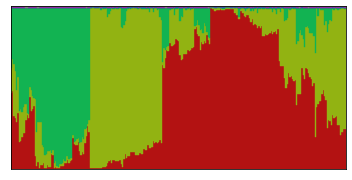

In [40]:
f, axarr = plt.subplots(1, 1, figsize=(6, 3))
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 5)

In [41]:
# reset sensitivity derivatives 

t0 = time.time()
vb_sens.set_derivatives(vb_opt, 
                        prior_params_paragami['dp_prior_alpha'].flatten(alpha1, 
                                                              free = use_free_alpha))
print(time.time() - t0)

61.019596099853516


In [42]:
# get new predictions
lr_free_params_list1 = get_lr_predictions(vb_sens)

lr time: 0.071145secs


In [43]:
lr_n_clusters_vec1 = get_num_clusters_vec(lr_free_params_list1, get_e_num_clusters)
lr_n_pred_clusters_vec1 = get_num_clusters_vec(lr_free_params_list1, get_e_num_pred_clusters)

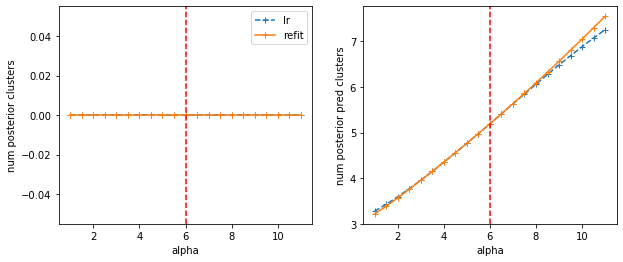

In [44]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# plot in-sample results
axarr[0].plot(alpha_vec, lr_n_clusters_vec1, '+--')
axarr[0].plot(alpha_vec, refit_n_clusters_vec, '+-')

axarr[0].set_xlabel('alpha')
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend(('lr', 'refit'))

# plot posterior-predictive results
axarr[1].plot(alpha_vec, lr_n_pred_clusters_vec1, '+--')
axarr[1].plot(alpha_vec, refit_n_pred_clusters_vec, '+-')

axarr[1].set_xlabel('alpha')
axarr[1].set_ylabel('num posterior pred clusters')

for i in range(2): 
    axarr[i].axvline(alpha1, color = 'red', linestyle = 'dashed')

In [45]:
for i in range(len(alpha_vec)): 
    np.savez('./figures/tmp/lr{}_results_ap{}'.format(alpha1, alpha_vec[i]), 
            free_params = lr_free_params_list1[i], 
            alpha_pert = alpha_vec[i], 
            alpha0 = alpha1)

# Start from a different alpha (again)

In [46]:
alpha2 = 9.0

which_fit = (alpha_vec == alpha2)

vb_opt = vb_refit_list[which_fit].squeeze()
vb_opt_dict = vb_params_paragami.fold(vb_opt,
                                      free = True)

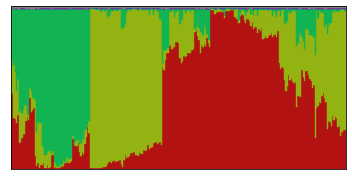

In [47]:
f, axarr = plt.subplots(1, 1, figsize=(6, 3))
e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]
e_ind_admix = plotting_utils.plot_top_clusters(e_ind_admix[indx], axarr, 
                                               n_top_clusters = 5)

In [48]:
# reset sensitivity derivatives 

t0 = time.time()
vb_sens.set_derivatives(vb_opt, 
                        prior_params_paragami['dp_prior_alpha'].flatten(alpha2, 
                                                              free = use_free_alpha))
print(time.time() - t0)

69.58722376823425


In [49]:
# get new predictions
lr_free_params_list2 = get_lr_predictions(vb_sens)

lr time: 0.076594secs


In [50]:
lr_n_clusters_vec2 = get_num_clusters_vec(lr_free_params_list2, get_e_num_clusters)
lr_n_pred_clusters_vec2 = get_num_clusters_vec(lr_free_params_list2, get_e_num_pred_clusters)

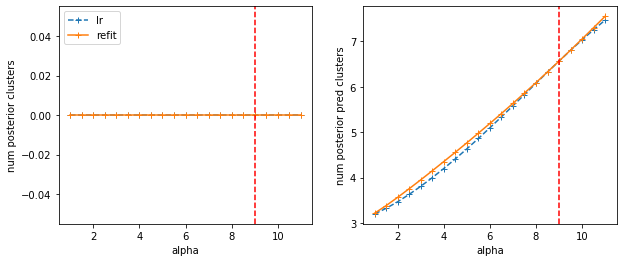

In [51]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# plot in-sample results
axarr[0].plot(alpha_vec, lr_n_clusters_vec2, '+--')
axarr[0].plot(alpha_vec, refit_n_clusters_vec, '+-')

axarr[0].set_xlabel('alpha')
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend(('lr', 'refit'))

# plot posterior-predictive results
axarr[1].plot(alpha_vec, lr_n_pred_clusters_vec2, '+--')
axarr[1].plot(alpha_vec, refit_n_pred_clusters_vec, '+-')

axarr[1].set_xlabel('alpha')
axarr[1].set_ylabel('num posterior pred clusters')

for i in range(2): 
    axarr[i].axvline(alpha2, color = 'red', linestyle = 'dashed')

In [53]:
for i in range(len(alpha_vec)): 
    np.savez('./figures/tmp/lr{}_results_ap{}'.format(alpha2, alpha_vec[i]), 
            free_params = lr_free_params_list2[i], 
            alpha_pert = alpha_vec[i], 
            alpha0 = alpha2)

# the final plot!

In [54]:
ax_ticksize = 12
ax_titlesize = 20
legend_fontsize = 16

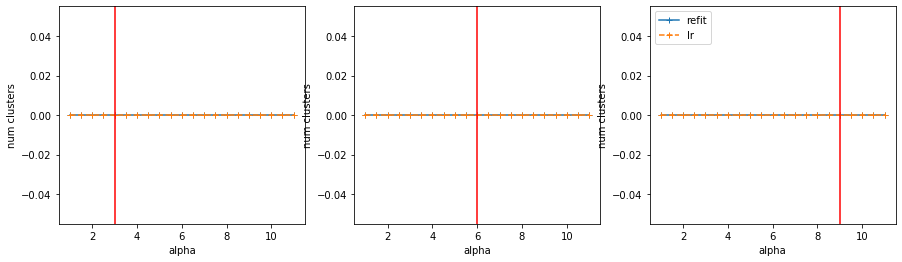

In [55]:
fig, axarr = plt.subplots(1, 3, figsize = (15, 4))

for i in range(3): 
    axarr[i].plot(alpha_vec, refit_n_clusters_vec, '+-', label = 'refit')
    axarr[i].set_xlabel('alpha')
    axarr[i].set_ylabel('num clusters')

    
axarr[0].plot(alpha_vec, lr_n_clusters_vec, '+--')
axarr[0].axvline(alpha0, color = 'red')

axarr[1].plot(alpha_vec, lr_n_clusters_vec1, '+--')
axarr[1].axvline(alpha1, color = 'red')

axarr[2].plot(alpha_vec, lr_n_clusters_vec2, '+--', label = 'lr')
axarr[2].axvline(alpha2, color = 'red')

axarr[2].legend()

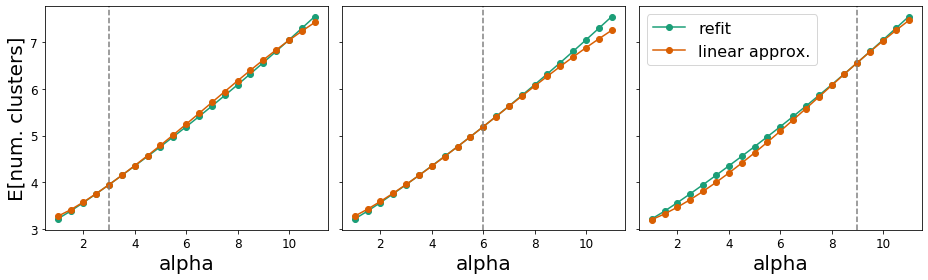

In [56]:
fig, axarr = plt.subplots(1, 3, figsize = (13, 4), sharey = True)

###############
# Plot refit values
###############
for i in range(3): 
    axarr[i].plot(alpha_vec, refit_n_pred_clusters_vec, 'o-', label = 'refit', 
                  color = '#1b9e77')

###############
# Plot linear approximation
###############    
axarr[0].plot(alpha_vec, lr_n_pred_clusters_vec, 'o-', 
              color = '#d95f02')
axarr[0].axvline(alpha0, color = 'grey', linestyle = '--')

axarr[1].plot(alpha_vec, lr_n_pred_clusters_vec1, 'o-', 
              color = '#d95f02')
axarr[1].axvline(alpha1, color = 'grey', linestyle = '--')

axarr[2].plot(alpha_vec, lr_n_pred_clusters_vec2, 'o-', 
              label = 'linear approx.', color = '#d95f02')
axarr[2].axvline(alpha2, color = 'grey', linestyle = '--')



##################
# Plottting asthetics
for i in range(3): 
    axarr[i].set_xlabel('alpha', fontsize = ax_titlesize)
    axarr[i].tick_params(axis='both', which='major', labelsize=ax_ticksize)
    
    
axarr[0].set_ylabel('E[num. clusters]', fontsize = ax_titlesize)
axarr[2].legend(fontsize = legend_fontsize)

fig.tight_layout()

In [48]:
import pandas as pd

In [70]:
df0 = pd.DataFrame(data = {'alpha': alpha_vec, 
                             'lr_pred': lr_n_pred_clusters_vec, 
                             'refit_pred': refit_n_pred_clusters_vec, 
                             'lr_insample': lr_n_clusters_vec, 
                             'refit_insample': refit_n_clusters_vec, 
                             'alpha0': alpha0})

In [71]:
df1 = pd.DataFrame(data = {'alpha': alpha_vec, 
                             'lr_pred': lr_n_pred_clusters_vec1, 
                             'refit_pred': refit_n_pred_clusters_vec, 
                             'lr_insample': lr_n_clusters_vec1, 
                             'refit_insample': refit_n_clusters_vec, 
                             'alpha0': alpha1})

In [72]:
df2 = pd.DataFrame(data = {'alpha': alpha_vec, 
                             'lr_pred': lr_n_pred_clusters_vec2, 
                             'refit_pred': refit_n_pred_clusters_vec, 
                             'lr_insample': lr_n_clusters_vec2, 
                             'refit_insample': refit_n_clusters_vec, 
                             'alpha0': alpha2})

In [73]:
df = df0.append(df1).append(df2)

In [74]:
df.to_csv('./figures/parametric_sens_data.csv', index = False)

In [59]:
 len(os.listdir('./figures/tmp/'))

84

In [44]:
# for loading in an already saved hessian inverse solution ... 

# class VBSensitivity(object): 
#     def __init__(self, lr_file, opt_par_value, hyper_par_value0): 
#         self.dinput_dhyper = np.load(lr_file)
        
#         self.opt_par_value = opt_par_value
#         self.hyper_par_value0 = hyper_par_value0
        
#     def predict_opt_par_from_hyper_par(self, hyper_par_value):
#         delta = (hyper_par_value - self.hyper_par_value0)

#         if len(self.dinput_dhyper.shape) == 1:
#             self.dinput_dhyper = np.expand_dims(self.dinput_dhyper, 1)

#         return np.dot(self.dinput_dhyper, delta) + self.opt_par_value

In [45]:
# load_lr_der = True
# if load_lr_der: 
#     lr_file = fit_dir + 'alpha_sens_nobs{}_nloci{}_npop{}_alpha{}.npy'.format(n_obs, 
#                                                                           n_loci, 
#                                                                           n_pop, 
#                                                                           alpha0)
#     vb_sens = VBSensitivity(lr_file, vb_opt, prior_alpha0)
# else: 
#     vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
#                                                         vb_opt,
#                                                         prior_alpha0, 
#                                                         cg_precond=cg_precond)

In [46]:
# def e_num_clusters_from_ez(vb_params_dict, gh_loc, gh_weights): 
#     e_log_sticks, e_log_1m_sticks, \
#         e_log_pop_freq, e_log_1m_pop_freq = \
#             structure_model_lib.get_moments_from_vb_params_dict(vb_params_dict,
#                                     gh_loc = gh_loc,
#                                     gh_weights = gh_weights)
#     e_log_cluster_probs = \
#         modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
#                             e_log_sticks, e_log_1m_sticks)
    
    
#     prod_ez = 1.
#     for l in range(g_obs.shape[1]):
#         _, e_z_l = structure_model_lib.get_optimal_ezl(g_obs[:, l],
#                                 e_log_pop_freq[l], e_log_1m_pop_freq[l],
#                                 e_log_cluster_probs)
        
#         prod_ez *= (1 - e_z_l).prod(2).prod(0)
                
#     return prod_ez